In [2]:
import pandas as pd
import numpy as np
import annoy
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Loading the required data

In [4]:
transactions=pd.read_csv('E:/H and M/HM Personal_Laptop/transactions_train.csv')

In [5]:
transactions.shape

(31788324, 5)

In [6]:
articles=pd.read_csv('E:/H and M/HM Personal_Laptop/articles.csv')

In [7]:
articles.shape

(105542, 25)

In [13]:
article_data=pd.read_csv('E:/H and M/HM Personal_Laptop/img_pres.csv')
article_data.drop('Unnamed: 0',inplace=True,axis=1)
article_data.head()

,0
0,0108775015.jpg
1,0108775044.jpg
2,0108775051.jpg
3,0110065001.jpg
4,0110065002.jpg


In [17]:
ids=list(articles.article_id)

In [18]:
articles=articles.loc[articles['article_id'].isin(ids)][['article_id','product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc']]
articles.shape

(105542, 25)

In [19]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


# Creating the vectors of articles

In [20]:
arts_data=articles.copy()
arts_data.set_index('article_id',inplace=True)
arts_data.head()

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [22]:
prod_name_enc = LabelEncoder()
group_name_enc = LabelEncoder()
index_enc = LabelEncoder()

arts_data['prod_name'] = prod_name_enc.fit_transform(arts_data['prod_name'].values.reshape(-1,1))
arts_data['product_group_name'] = group_name_enc.fit_transform(arts_data['product_group_name'].values.reshape(-1,1))
arts_data['index_name'] = index_enc.fit_transform(arts_data['index_name'].values.reshape(-1,1))

C:\Users\Convergytics\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
arts_data.head()

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,40763,253,Vest top,7,1010016,Solid,9,Black,4,...,Jersey Basic,A,6,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,40763,253,Vest top,7,1010016,Solid,10,White,3,...,Jersey Basic,A,6,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,40764,253,Vest top,7,1010017,Stripe,11,Off White,1,...,Jersey Basic,A,6,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,110065,30468,306,Bra,16,1010016,Solid,9,Black,4,...,Clean Lingerie,B,7,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,110065,30468,306,Bra,16,1010016,Solid,10,White,3,...,Clean Lingerie,B,7,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [24]:
dims = [
    'prod_name',
    'product_type_no',
    'product_group_name',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_name',
    'index_group_no',
    'section_no',
    'garment_group_no'
]

In [25]:
vector = np.ascontiguousarray(arts_data[dims].values, dtype=np.float32)
items = np.array(arts_data.index)

In [26]:
print(vector[10])
print(items[10])

[2.890000e+02 3.040000e+02 1.300000e+01 1.010016e+06 9.000000e+00
 4.000000e+00 5.000000e+00 3.608000e+03 7.000000e+00 1.000000e+00
 6.200000e+01 1.021000e+03]
111609001


In [27]:
vector.shape

(105542, 12)

In [28]:
item_data = {"id":items,"vector":vector}

In [30]:
item_data

{'id': array([108775015, 108775044, 108775051, ..., 956217002, 957375001,
        959461001], dtype=int64),
 'vector': array([[4.0763e+04, 2.5300e+02, 7.0000e+00, ..., 1.0000e+00, 1.6000e+01,
         1.0020e+03],
        [4.0763e+04, 2.5300e+02, 7.0000e+00, ..., 1.0000e+00, 1.6000e+01,
         1.0020e+03],
        [4.0764e+04, 2.5300e+02, 7.0000e+00, ..., 1.0000e+00, 1.6000e+01,
         1.0020e+03],
        ...,
        [8.2560e+03, 2.6500e+02, 5.0000e+00, ..., 1.0000e+00, 1.8000e+01,
         1.0050e+03],
        [6.9530e+03, 7.2000e+01, 0.0000e+00, ..., 2.0000e+00, 5.2000e+01,
         1.0190e+03],
        [2.5218e+04, 2.6500e+02, 5.0000e+00, ..., 1.0000e+00, 1.8000e+01,
         1.0050e+03]], dtype=float32)}

# Applying Annoy for finding the similar items

In [31]:
class AnnoyIndex():
    def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels   
        self.search_in_x_trees = 10
   
    def build(self, number_of_trees=200):
        self.index = annoy.AnnoyIndex(self.dimension,metric='manhattan')
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=10):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=self.search_in_x_trees)                                           
        return [self.labels[i] for i in indices]

In [32]:
index = AnnoyIndex(item_data['vector'],item_data['id'])
index.build(100)

In [33]:
dd = {"item":[],"similar_items":[]}
for x in tqdm(range(len(item_data['vector']))):
    similar_items = index.query(item_data['vector'][x])
    dd['item'].append(item_data['id'][x])
    dd['similar_items'].append(similar_items)

  0%|          | 0/105542 [00:00<?, ?it/s]

# Similar items dataframe

In [34]:
item_similarities = pd.DataFrame(dd)
item_similarities.dtypes

item              int64
similar_items    object
dtype: object

In [35]:
item_similarities

,item,similar_items
0,108775015,"[736870005, 824999001, 824999002, 824999003, 5..."
1,108775044,"[736870005, 824999001, 824999002, 824999003, 5..."
2,108775051,"[824999002, 824999003, 824999001, 736870005, 5..."
3,110065001,"[153115021, 749276001, 531697003, 473954006, 8..."
4,110065002,"[153115021, 749276001, 531697003, 878629004, 4..."
...,...,...
105537,953450001,"[953450001, 452818029, 584631051, 584631061, 5..."
105538,953763001,"[906696003, 904916001, 926469001, 573152032, 7..."
105539,956217002,"[956217002, 581175001, 738883001, 608656003, 7..."
105540,957375001,"[682260006, 682260008, 692783006, 692783002, 6..."


In [36]:
a=list(item_similarities[item_similarities['item']==int(108775015)]['similar_items'])[0]
a

[736870005,
 824999001,
 824999002,
 824999003,
 594519004,
 751530001,
 751530004,
 765599005,
 537018003,
 566149001]

In [ ]:
item_similarities.to_csv('content_based_similar_items.csv')

In [37]:
item_similarities.head()

,item,similar_items
0,108775015,"[736870005, 824999001, 824999002, 824999003, 5..."
1,108775044,"[736870005, 824999001, 824999002, 824999003, 5..."
2,108775051,"[824999002, 824999003, 824999001, 736870005, 5..."
3,110065001,"[153115021, 749276001, 531697003, 473954006, 8..."
4,110065002,"[153115021, 749276001, 531697003, 878629004, 4..."


In [38]:
item_similarities.shape

(105542, 2)

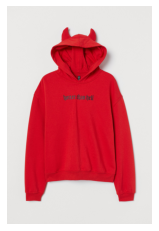

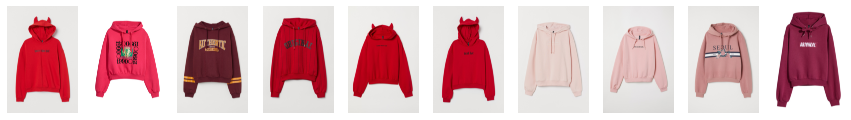

In [39]:
idd = str(874110016)
path = f"E:/H and M/HM Personal_Laptop/images/0{idd[0:2]}/0{idd}.jpg"
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

similar_items = list(item_similarities[item_similarities['item']==int(idd)]['similar_items'])[0]
_,ax = plt.subplots(1,len(similar_items),figsize=(15,10))

for i,x in enumerate(similar_items):
    id = str(x)
    path = f"E:/H and M/HM Personal_Laptop/images/0{id[0:2]}/0{id}.jpg"
    img = mpimg.imread(path)
    ax[i].imshow(img)
    ax[i].axis('off')
    
plt.show()

# Recommendation using content based item similarity

In [40]:
transactions.shape

(31788324, 5)

In [41]:
transact_data=transactions[0:30000]
transact_data.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [42]:
test_data = transactions.groupby(by="customer_id")['article_id'].agg(list).reset_index()
test_data.head(25)

,customer_id,article_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[625548001, 176209023, 627759010, 697138006, 5..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[583558001, 639677008, 640244003, 521269001, 6..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[663713001, 541518023, 663713001, 578020002, 7..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"[742079001, 732413001]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[634249005, 677049001, 698286003, 707704003, 3..."
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,"[738133005, 680265002, 740962001]"
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"[735843004, 726925001, 715624008, 783388001, 7..."
7,00007d2de826758b65a93dd24ce629ed66842531df6699...,"[505221004, 685687003, 685687004, 685687001, 5..."
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,"[819423001, 850614001]"
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,"[673677001, 551080020, 648414023, 673677004]"


final_list=[]
for i,j in zip(test_data['customer_id'],test_data['article_id']):
    arts_list=[]
    for x in j:
        arts_list.append(str(x))
    final_list.append(arts_list[0])
print(final_list)

In [43]:
test_data.iloc[2,0]

'000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318'

In [45]:
test_data.iloc[2,1]

[663713001,
 541518023,
 663713001,
 578020002,
 723529001,
 351484002,
 351484002,
 727808001,
 727808007,
 858883002,
 851400006,
 750424014,
 750424014,
 870304002,
 870304002,
 852643001,
 852643003,
 794321007]

[663713001, 541518023, 663713001, 578020002, 723529001, 351484002, 351484002, 727808001, 727808007, 858883002, 851400006, 750424014, 750424014, 870304002, 870304002, 852643001, 852643003, 794321007]
[663713001, 541518023, 663713001, 578020002, 723529001, 351484002, 351484002, 727808001, 727808007, 858883002, 851400006, 750424014, 750424014, 870304002, 870304002, 852643001, 852643003, 794321007]
     products             article_ids
0  Bikini top             [723529001]
1      Blouse  [578020002, 858883002]
2         Bra             [541518023]
3      Jacket             [794321007]
4       Shirt  [870304002, 870304002]
['723529001', '578020002', '541518023', '794321007', '870304002', '851400006', '727808001', '351484002', '750424014', '663713001']


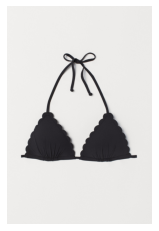

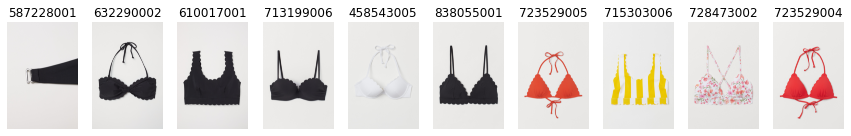

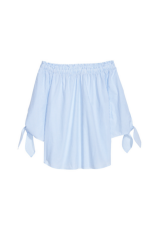

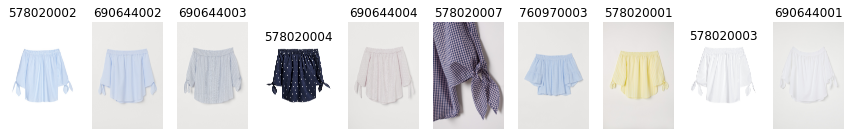

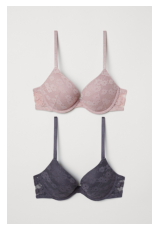

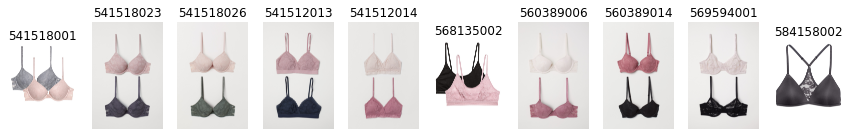

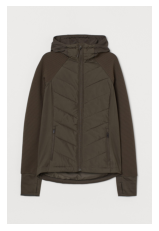

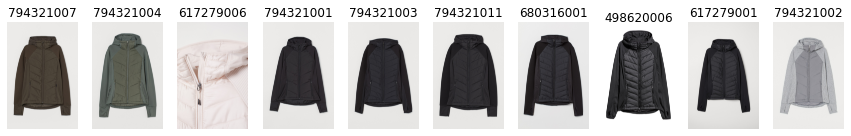

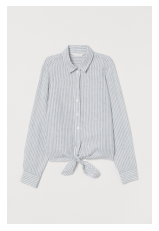

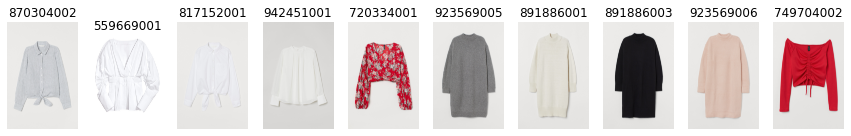

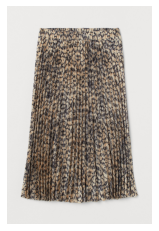

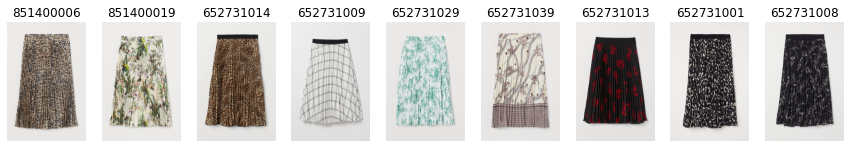

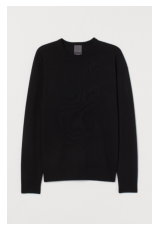

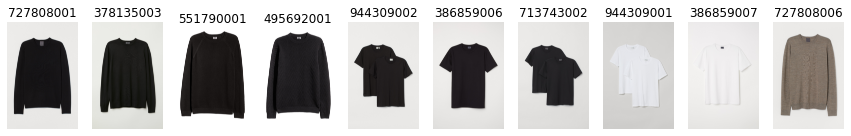

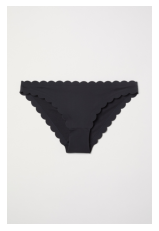

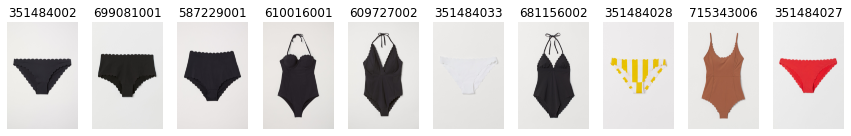

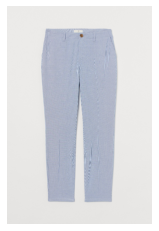

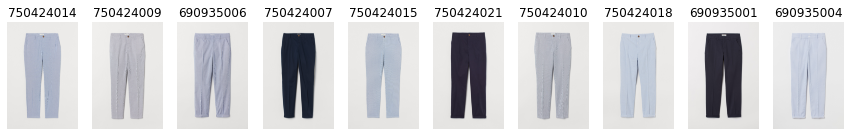

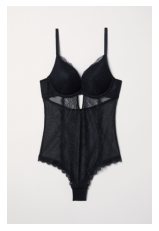

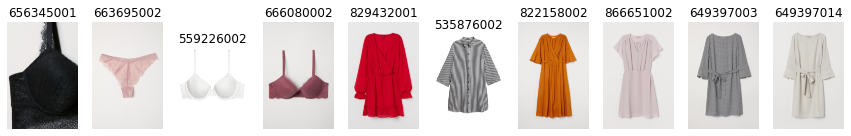

In [54]:
cust_id='000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318'
index_pos=test_data[test_data['customer_id']==cust_id].index.values
arts=test_data.iloc[index_pos[0],1]
print(arts)
products=[]
items=[]
for a in arts:
    art_index=articles[articles.article_id==a].index.values
    products.append(articles.at[art_index[0],'product_type_name'])
    items.append(a)
print(items)
unique_items=pd.DataFrame()
unique_items['products']=pd.Series(products)
unique_items['article_ids']=pd.Series(items)
unique_products=unique_items.groupby('products')['article_ids'].agg(list).reset_index()
print(unique_products.head())
final_list=[]
for i,j in zip(unique_products['products'],unique_products['article_ids']):
    arts_list=[]
    for x in j:
        arts_list.append(str(x))
    final_list.append(arts_list[0])
print(final_list)
for ids in final_list:
    idd = str(ids)
    path = f"E:/H and M/HM Personal_Laptop/images/0{idd[0:2]}/0{idd}.jpg"
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

    similar_items = list(item_similarities[item_similarities['item']==int(idd)]['similar_items'])[0]
    _,ax = plt.subplots(1,len(similar_items),figsize=(15,10))

    for i,x in enumerate(similar_items):
        id = str(x)
        path = f"E:/H and M/HM Personal_Laptop/images/0{id[0:2]}/0{id}.jpg"
        img = mpimg.imread(path)
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(id)
    plt.show()

    
    

[823791006]
[823791006]
  products  article_ids
0   Blazer  [823791006]
['823791006']


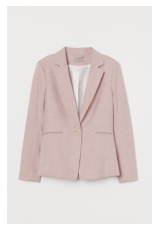

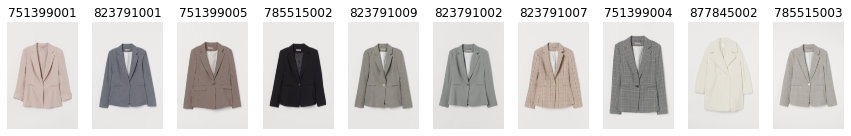

In [55]:
cust_id='003fa2185a45ddf59461a5ccb2167fbadff76f297e57f9a5014f096d5a7b49de'
index_pos=test_data[test_data['customer_id']==cust_id].index.values
arts=test_data.iloc[index_pos[0],1]
print(arts)
products=[]
items=[]
for a in arts:
    art_index=articles[articles.article_id==a].index.values
    products.append(articles.at[art_index[0],'product_type_name'])
    items.append(a)
print(items)
unique_items=pd.DataFrame()
unique_items['products']=pd.Series(products)
unique_items['article_ids']=pd.Series(items)
unique_products=unique_items.groupby('products')['article_ids'].agg(list).reset_index()
print(unique_products.head())
final_list=[]
for i,j in zip(unique_products['products'],unique_products['article_ids']):
    arts_list=[]
    for x in j:
        arts_list.append(str(x))
    final_list.append(arts_list[0])
print(final_list)
for ids in final_list:
    idd = str(ids)
    path = f"E:/H and M/HM Personal_Laptop/images/0{idd[0:2]}/0{idd}.jpg"
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

    similar_items = list(item_similarities[item_similarities['item']==int(idd)]['similar_items'])[0]
    _,ax = plt.subplots(1,len(similar_items),figsize=(15,10))

    for i,x in enumerate(similar_items):
        id = str(x)
        path = f"E:/H and M/HM Personal_Laptop/images/0{id[0:2]}/0{id}.jpg"
        img = mpimg.imread(path)
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(id)
    plt.show()

    
    